<a href="https://colab.research.google.com/github/HersheyZinc/Screw_classifier/blob/main/Model_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data preprocessing**

## Import data and libraries

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt

import os
import numpy as np
import matplotlib.pyplot as plt


TRAIN_TEST_DIR="/content/gdrive/MyDrive/Colab Notebooks/DEEP/train-test"
VAL_DIR = "/content/gdrive/MyDrive/Colab Notebooks/DEEP/validation"
IMG_WIDTH = 256
IMG_HEIGHT = 256
batch_size = 50
epochs = 15

types = ["M6_12","M6_10", "M4_10","M4_16"]
types = os.listdir(TRAIN_TEST_DIR)

In [ ]:
total = 0
for name in types:
  img_count = len(os.listdir(os.path.join(TRAIN_TEST_DIR,name)))
  total+=img_count
  print("{} images: {}".format(name, img_count))

print("Total images found: {}".format(total))

M6_12 images: 573
M6_10 images: 510
M4_10 images: 458
M4_16 images: 510
None images: 480
Total images found: 2531


## Image Generators

In [ ]:
#Create Image generators for train and test datasets
image_generator = ImageDataGenerator(rescale=1./255,rotation_range=15,horizontal_flip=True,brightness_range=(0.7,1.2),validation_split=0.2) 
train_data_gen = image_generator.flow_from_directory(batch_size=batch_size,
                                                      directory=TRAIN_TEST_DIR,
                                                      shuffle=True,
                                                      target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                      class_mode='categorical',subset="training")

test_data_gen = image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=TRAIN_TEST_DIR,
                                                              target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                              class_mode='categorical',subset="validation")
train_size, test_size = train_data_gen.samples, test_data_gen.samples

Found 2026 images belonging to 5 classes.
Found 505 images belonging to 5 classes.


In [ ]:
val_data_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(VAL_DIR, batch_size=24,target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                           class_mode='categorical')

Found 48 images belonging to 5 classes.


In [ ]:
labels = (train_data_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
def getType(arr):
  for i in range(len(arr)):
    if arr[i] == 1:
      return labels[i]

In [ ]:
labels

{0: 'M4_10', 1: 'M4_16', 2: 'M6_10', 3: 'M6_12', 4: 'None'}

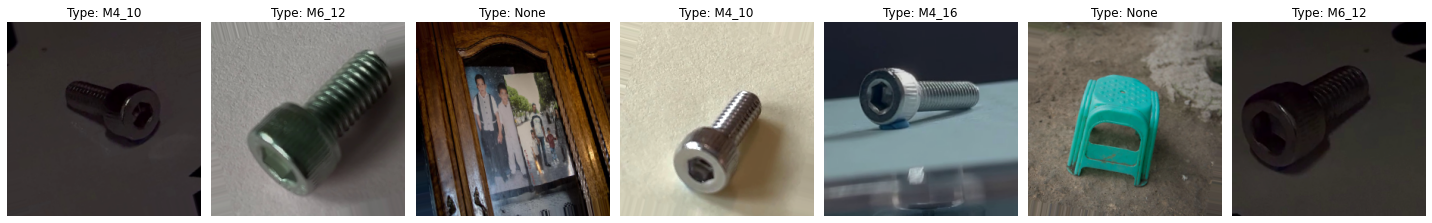

In [ ]:
#Check 7 random images from train image generator
sample_training_images, category = next(train_data_gen)
images_arr = sample_training_images[:7]

fig, axes = plt.subplots(1, 7, figsize=(20,20))
axes = axes.flatten()
for img, ax, act in zip( images_arr, axes, category[:7]):
    ax.imshow(img)
    ax.axis('off')
    ax.title.set_text("Type: {}".format(getType(act)))
plt.tight_layout()
plt.show()

## Evaluation functions

In [ ]:
def predict(model, img):
  img = np.expand_dims(img, axis=0)
  prediction = model.predict(img).argmax(axis=1)[0]
  return labels[prediction]

In [ ]:
def validation_report(generator, model):
  images_arr, actual = next(generator)[:25]
  predictions = model.predict(images_arr).argmax(axis=1)
  correct = 0

  fig, axes = plt.subplots(2, 12, figsize=(20,5))
  axes = axes.flatten()
  for img, ax, pred, act in zip(images_arr, axes, predictions, actual):
      ax.imshow(img)
      ax.axis('off')
      ax.title.set_text("Pred: {}\nActual: {}".format(labels[pred], getType(act)))
      if labels[pred] == getType(act):
        correct +=1
  plt.tight_layout()
  plt.show()
  print("Score: {}/{} correct".format(correct,24))

In [ ]:
def hist_report(hist):
  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  epoch = range(len(loss))

  plt.figure(figsize=(20, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epoch,loss,label='loss')
  plt.plot(epoch,val_loss,label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epoch,acc,label='acc')
  plt.plot(epoch,val_acc,label='val_acc')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()

# **Inception model**

Here, we download the pre-trained model InceptionV3 from tensorflow. We the configure the layers such that they are not trainable. Finally, we add in our own trainable last layer and compile the model

## Train the model

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
os.chdir("/content/gdrive/MyDrive/Colab Notebooks/DEEP")
model_incept = load_model("Model_incept")

In [ ]:
base_model = InceptionV3(input_shape = (IMG_WIDTH, IMG_HEIGHT, 3), include_top = False, weights = 'imagenet')

# Disable training for all layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.3)(x)

# Add a final softmax layer with 1 node for classification output
x = layers.Dense(5, activation='softmax')(x)

In [ ]:
model_incept = Model(base_model.input, x)

In [ ]:
model_incept.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 4
batch_size=64

history_incept = model_incept.fit(
    train_data_gen,
    steps_per_epoch=train_size//batch_size,
    epochs=epochs,
    validation_data=test_data_gen,
    validation_steps=test_size//batch_size
)

Epoch 1/4
31/31 [==============================] - 328s 10s/step - loss: 15.5235 - accuracy: 0.6429 - val_loss: 0.7535 - val_accuracy: 0.9000
Epoch 2/4
31/31 [==============================] - 320s 10s/step - loss: 1.5452 - accuracy: 0.8362 - val_loss: 0.8604 - val_accuracy: 0.8571
Epoch 3/4
31/31 [==============================] - 322s 10s/step - loss: 0.7088 - accuracy: 0.8958 - val_loss: 0.2699 - val_accuracy: 0.9200
Epoch 4/4
31/31 [==============================] - 320s 10s/step - loss: 0.2745 - accuracy: 0.9318 - val_loss: 0.1952 - val_accuracy: 0.9429


# Evaluate the model

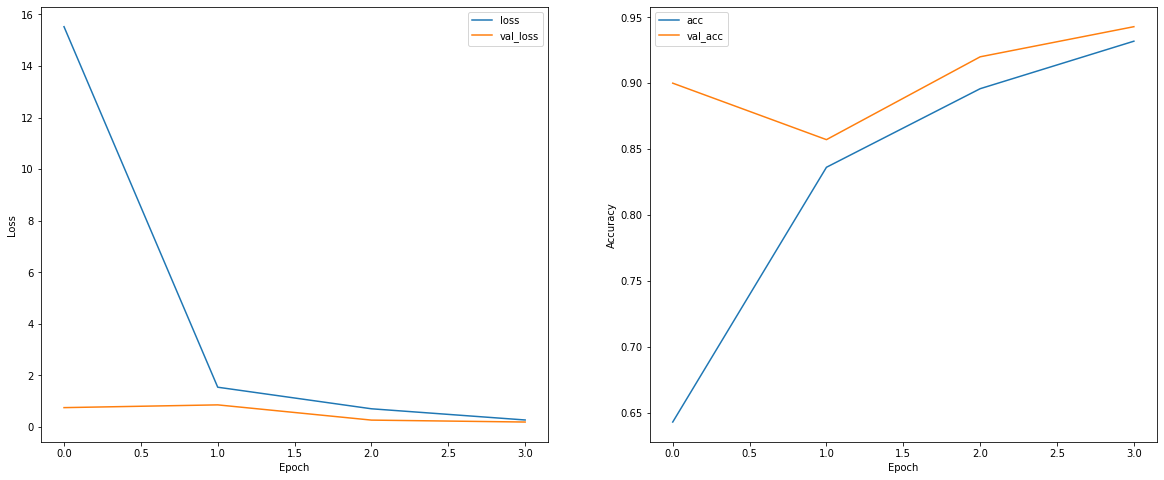

In [ ]:
hist_report(history_incept)

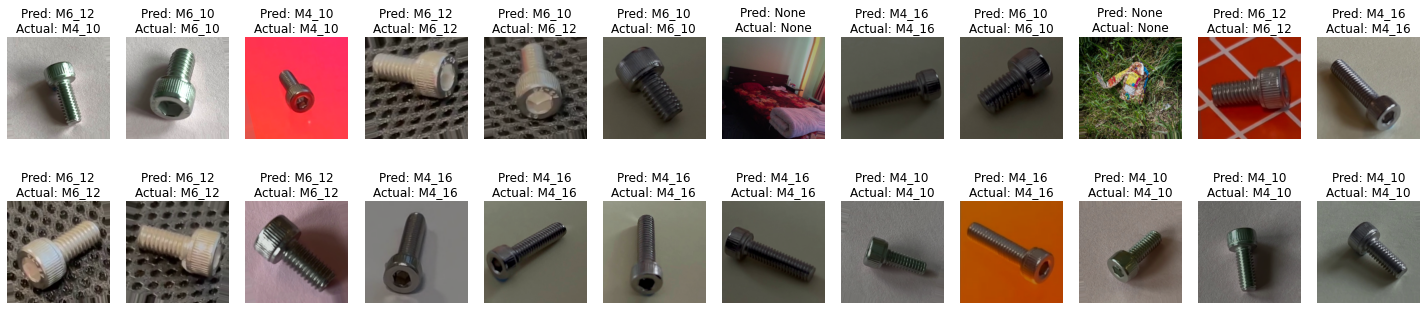

Score: 22/24 correct


In [ ]:
validation_report(test_data_gen,model_incept)

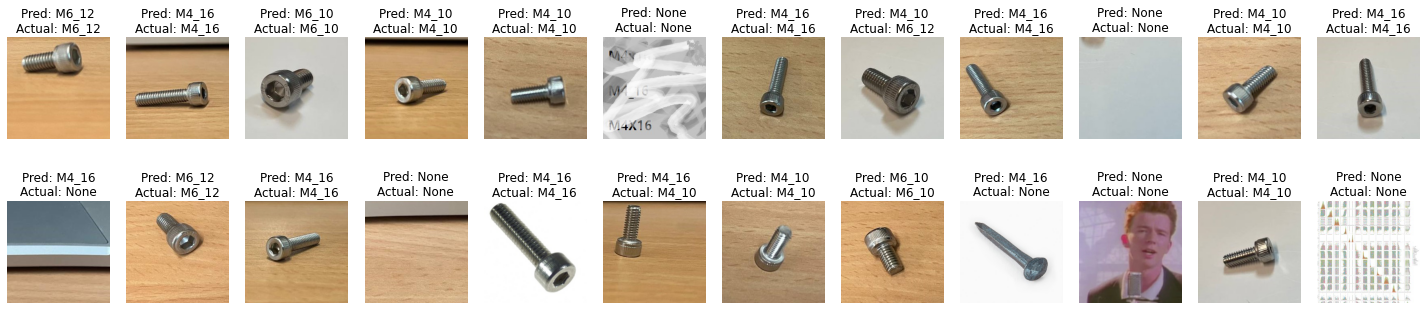

Score: 20/24 correct


In [ ]:
validation_report(val_data_gen,model_incept)

## Observation

The Inception model has done very well for train, test, and validation accuracy scores. It has very high potential to be useful in our project's application, we download the trained parameters to be loaded in our telegram code

In [ ]:
os.chdir("/content/gdrive/MyDrive/Colab Notebooks/DEEP")
model_incept.save("Model_incept")

INFO:tensorflow:Assets written to: Model_incept/assets


#**VGG16**

Similar to the inception model, I imported the VGG16 base model from tensorflow and added my own final layer for training

## Train the model

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
base_model = VGG16(input_shape = (IMG_WIDTH, IMG_HEIGHT, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

In [ ]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(5, activation='softmax')(x)

In [ ]:
model_VGG16 = Model(base_model.input, x)

In [ ]:
model_VGG16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 8
batch_size=64

history_VGG16 = model_VGG16.fit(
    train_data_gen,
    steps_per_epoch=train_size//batch_size,
    epochs=epochs,
    validation_data=test_data_gen,
    validation_steps=test_size//batch_size
)

Epoch 1/8
31/31 [==============================] - 1303s 42s/step - loss: 5.7112 - accuracy: 0.4469 - val_loss: 1.1432 - val_accuracy: 0.7829
Epoch 2/8
31/31 [==============================] - 1288s 42s/step - loss: 0.5765 - accuracy: 0.7844 - val_loss: 0.7450 - val_accuracy: 0.7800
Epoch 3/8
31/31 [==============================] - 1282s 42s/step - loss: 0.3035 - accuracy: 0.8899 - val_loss: 0.6182 - val_accuracy: 0.8543
Epoch 4/8
31/31 [==============================] - 1277s 41s/step - loss: 0.2075 - accuracy: 0.9299 - val_loss: 0.4934 - val_accuracy: 0.8829
Epoch 5/8
31/31 [==============================] - 1275s 41s/step - loss: 0.1637 - accuracy: 0.9463 - val_loss: 0.5877 - val_accuracy: 0.8771
Epoch 6/8
31/31 [==============================] - 1277s 41s/step - loss: 0.1387 - accuracy: 0.9502 - val_loss: 0.5870 - val_accuracy: 0.8771
Epoch 7/8
31/31 [==============================] - 1281s 42s/step - loss: 0.1596 - accuracy: 0.9430 - val_loss: 0.6855 - val_accuracy: 0.8771
Epoch 

## Evaluate the model

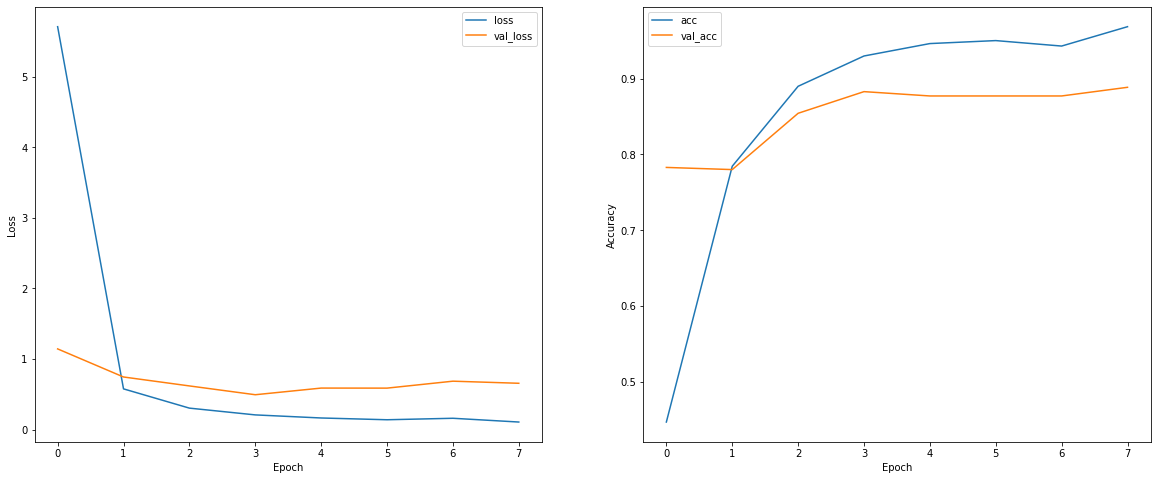

In [ ]:
hist_report(history_VGG16)

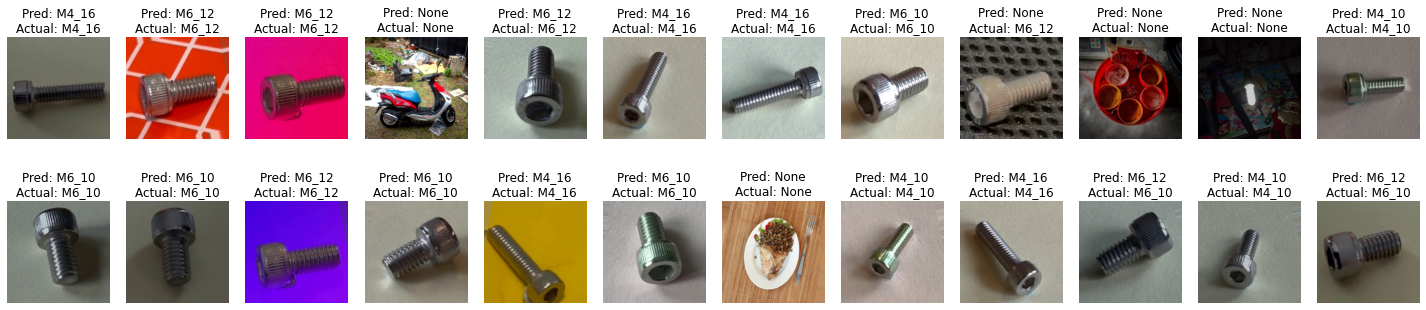

Score: 21/24 correct


In [ ]:
validation_report(test_data_gen,model_VGG16)

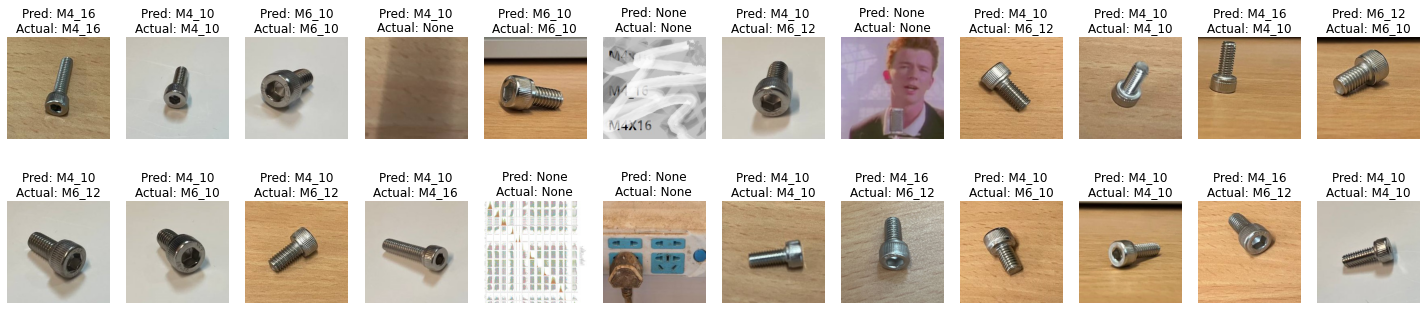

Score: 12/24 correct


In [ ]:
validation_report(val_data_gen,model_VGG16)

## Observation

Like the first model we tried, VGG16 showed great results for train and test datasets. However, it only scored slightly above 50% for the validation data. This indicates that the model is unable to successfully generalize the screws' features, and could be attributed to the slow learning rate of VGG16